In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET

from collections import defaultdict, Counter

In [14]:
sns.set(style="whitegrid")

# ETS allowance exploration

## Load data

In [91]:
YEARS = ['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [92]:
tree = ET.parse('data/france_allowances_phase3.xml')
root = tree.getroot()

## Data exploration

In [93]:
installationNodes = root.findall(".//AllocationTableOperatorInformationPublic/AllocationTableOperatorInformation")

In [94]:
rows = []
for installationNode in installationNodes:
    row = [
        installationNode.find('Status').text,
        installationNode.find('AccountHolderName').text,
        installationNode.find('InstallationName').text
    ]
    for year in YEARS:
        try:
            row.append(int(installationNode.find('allocation'+year).text))
        except:
            row.append(None)
    rows.append(row)

In [95]:
data = pd.DataFrame(
    rows,
    columns=[
        'status',
        'accountHolderName',
        'installationName',
        '2013',
        '2014',
        '2015',
        '2016',
        '2017',
        '2018',
        '2019',
        '2020'
    ]
)

In [96]:
data.head()

,status,accountHolderName,installationName,2013,2014,2015,2016,2017,2018,2019,2020
0,Active,NESTLE FRANCE SAS,NESTLE FRANCE - Boué,18618.0,16661.0,22459.0,22046.0,21628.0,21206,20779,20351
1,Active,TEREOS FRANCE,Sucrerie de Bucy,84637.0,83167.0,81680.0,80177.0,78659.0,77125,75572,74013
2,Active,WEPA GREENFIELD SAS,WEPA GREENFIELD SAS,4599.0,4519.0,4438.0,4356.0,4274.0,4190,4106,4021
3,Permit Revoked,ARKEMA FRANCE,ARKEMA FRANCE - Usine de Chauny,64889.0,63762.0,0.0,0.0,0.0,0,0,0
4,Active,VERALLIA FRANCE,VERALLIA FRANCE - Vauxrot,58178.0,57167.0,56145.0,55113.0,54068.0,53014,51947,50875


### Number installations

In [99]:
data.shape

(1151, 11)

### Proportion of None or zero

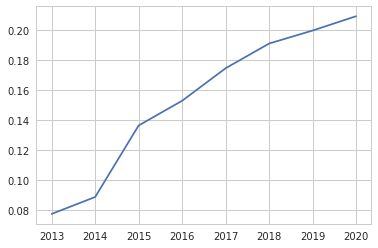

In [100]:
p = [data[(data[year] == 0) | (data[year].isnull())].shape[0] / data.shape[0] for year in YEARS]
plt.plot(YEARS, p)
plt.show()

### Proportion of statuses

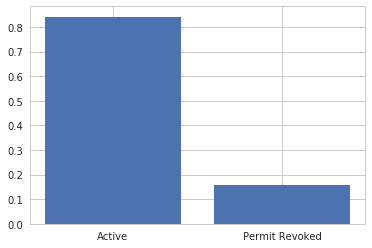

In [101]:
c = data['status'].value_counts()
plt.bar(c.keys(), c / c.sum())
plt.show()

### Total number of allocations per year

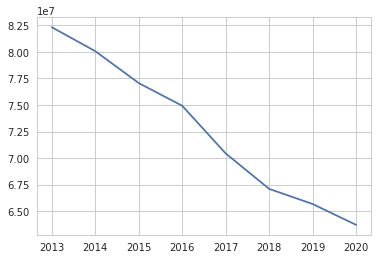

In [102]:
sums = [data[year].sum() for year in YEARS]
plt.plot(YEARS, sums)
plt.show()

### Relative yearly trend

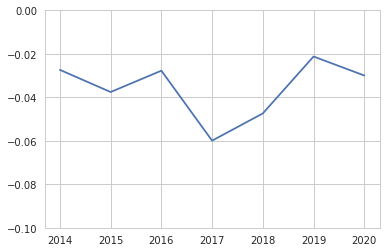

In [103]:
relativeTrends = [(sums[i+1] - sums[i]) / sums[i] for i in range(len(sums)-1)]
plt.plot(YEARS[1:], relativeTrends)
axes = plt.gca()
axes.set_ylim((-0.1, 0))
plt.show()

### Allocations distribution

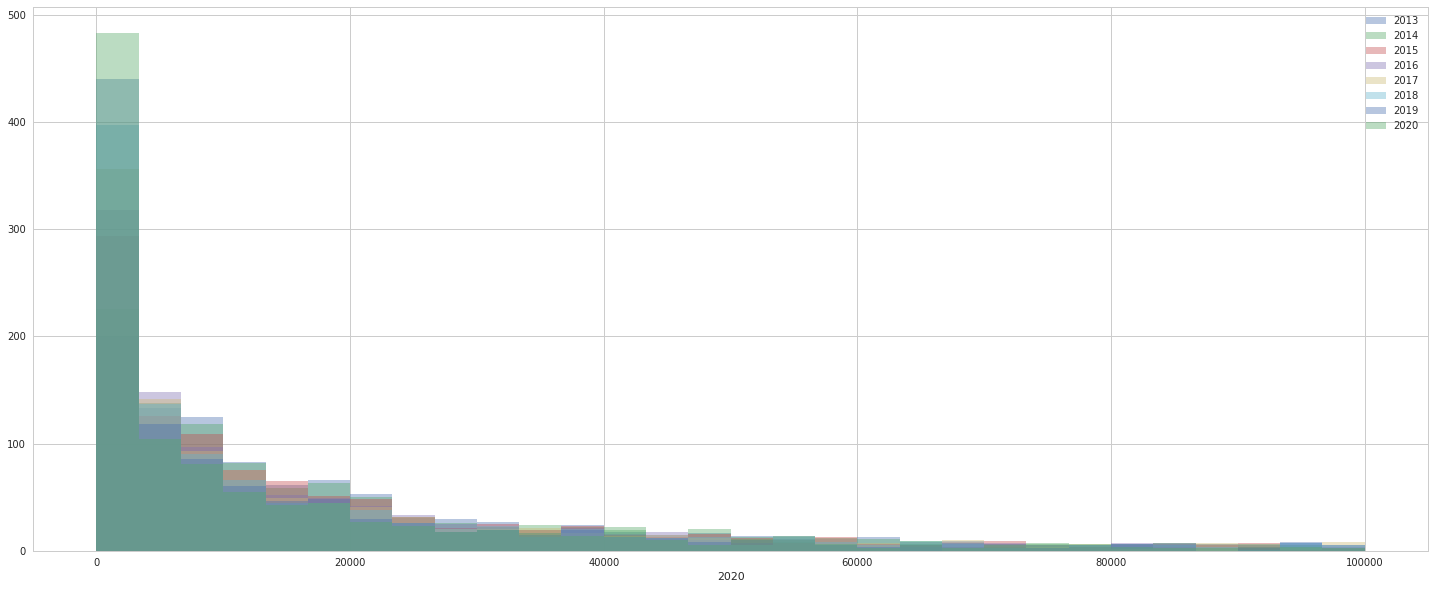

In [104]:
MIN, MAX = 0, 100000
plt.figure(figsize=(25,10))

for year in YEARS:
    sns.distplot(
        data[data[year] < MAX][year],
        bins=30,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        },
        label=year
    )
plt.legend()
plt.show()

#### Distribution using stripplot

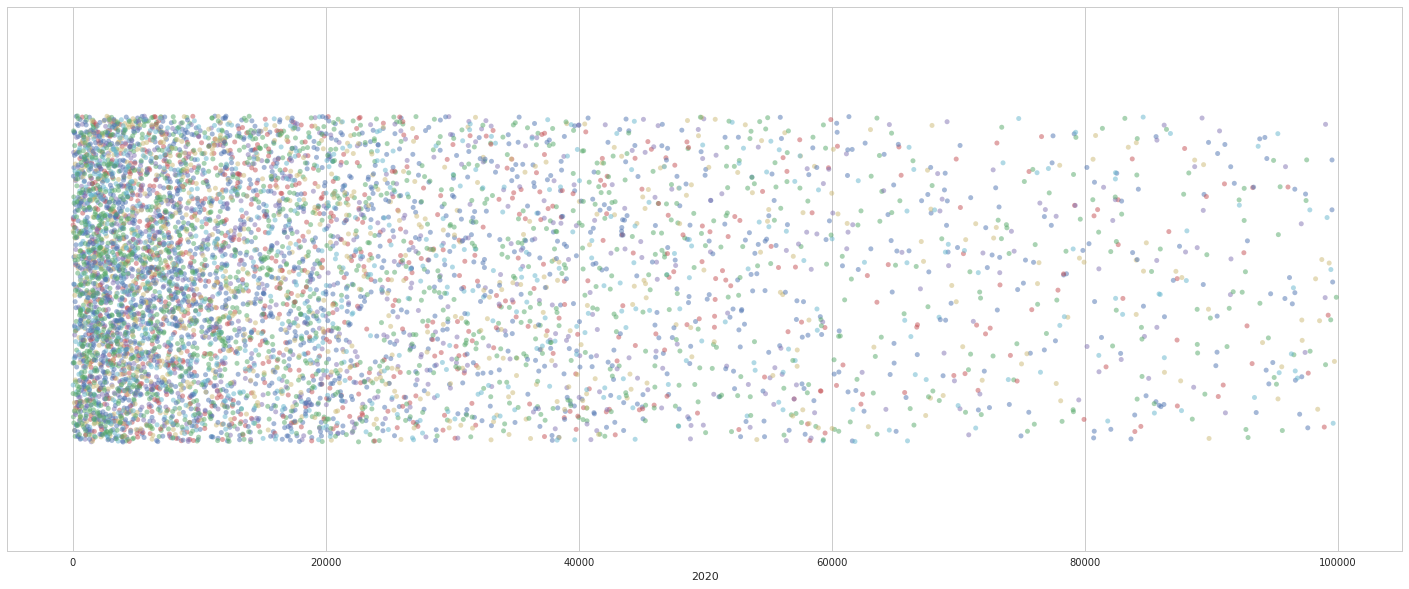

In [117]:
MIN, MAX = 1, 100000
# plt.figure(figsize=(25, 5 * len(YEARS)))
plt.figure(figsize=(25, 10))

ax = plt.gca()

for i, year in enumerate(YEARS):
#     ax = plt.subplot(len(YEARS), 1, i+1)
    color = sns.color_palette(n_colors=len(YEARS))[i]
    sns.stripplot(
        x=year,
        data=data[(data[year] > MIN) & (data[year] < MAX)],
        jitter=0.3,
        ax=ax,
        color=color,
        alpha=0.5
    )
plt.show()

#### Log distribution

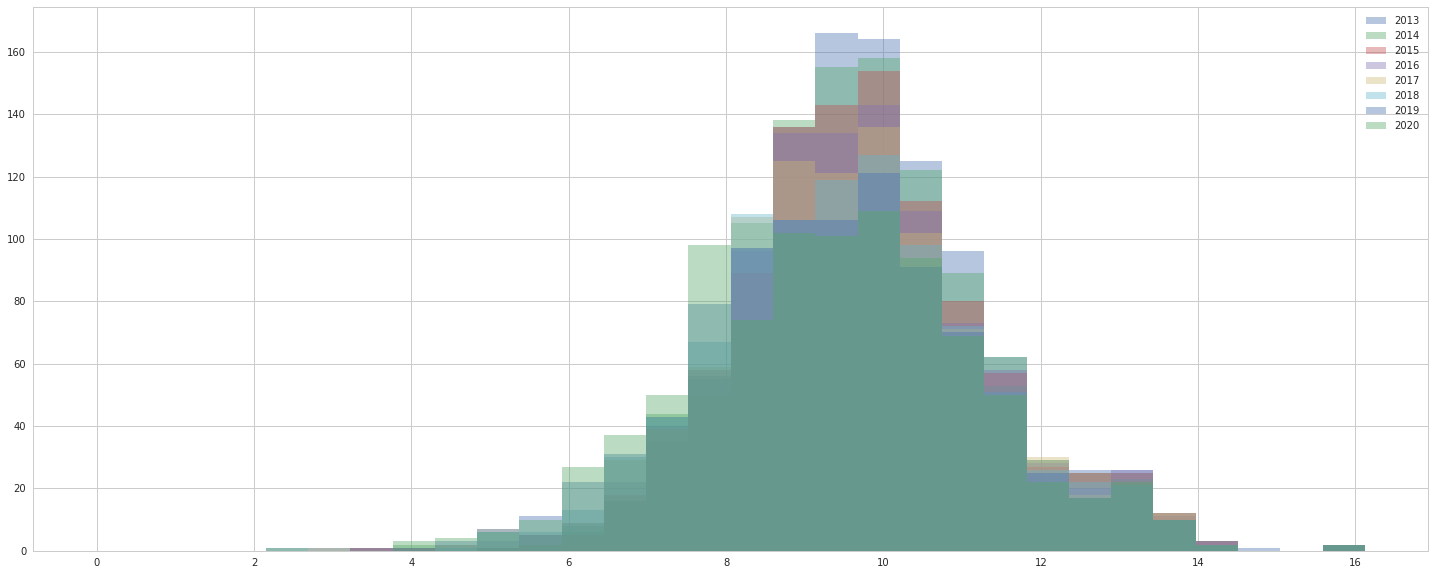

In [112]:
MIN, MAX = 1, 10000000
plt.figure(figsize=(25,10))

for year in YEARS:
    sns.distplot(
        np.log(np.array(data[(data[year] > MIN) & (data[year] < MAX)][year])),
        bins=30,
        kde=False,
        hist_kws={
            "range": (np.log(MIN), np.log(MAX))
        },
        label=year
    )
plt.legend()
plt.show()

### Most carbonated installations' dynamics

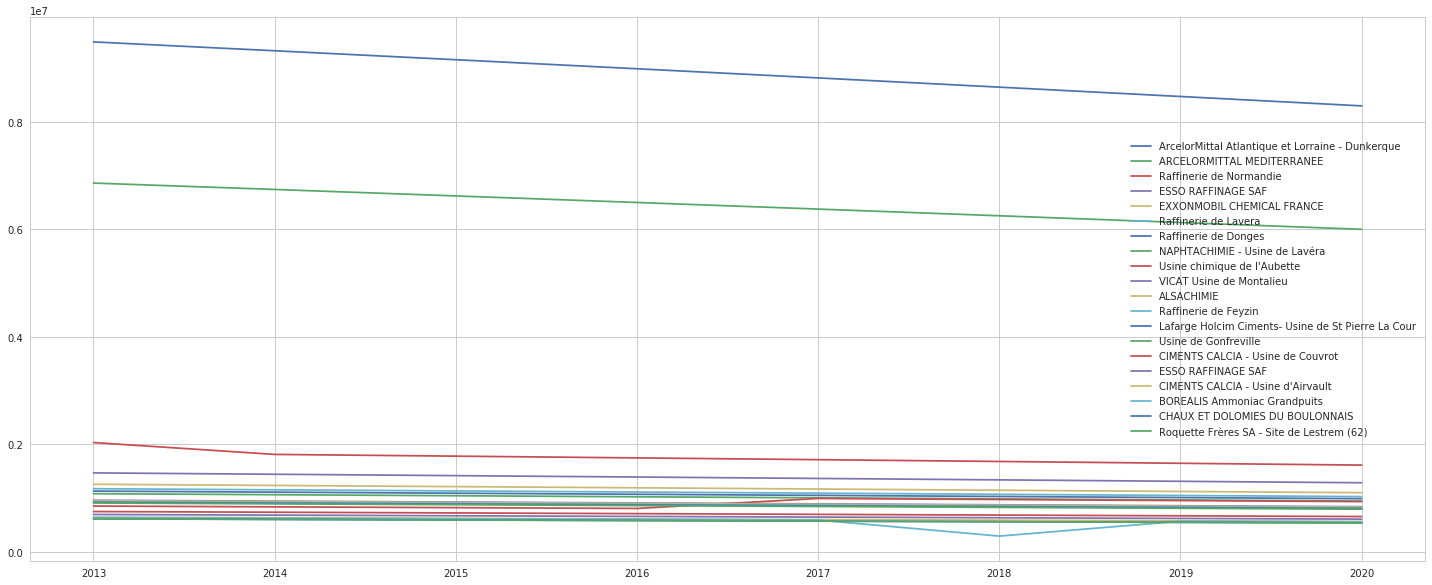

In [145]:
plt.figure(figsize=(25,10))
ds = data.sort_values(by=['2020'], ascending=False)
for installation in ds[:20].iterrows():
    plt.plot(YEARS, installation[1][YEARS], label=installation[1]['installationName'])
plt.legend()
plt.show()

### Annual distribution of relative trends

One computes the evolution of allocations from year `n-1` to year `n`

In [165]:
for year in YEARS[1:]:
    previousYear = str(int(year) - 1)
    data['r' + year] = (data[year] - data[previousYear]) / data[previousYear]

/home/alexis/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alexis/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


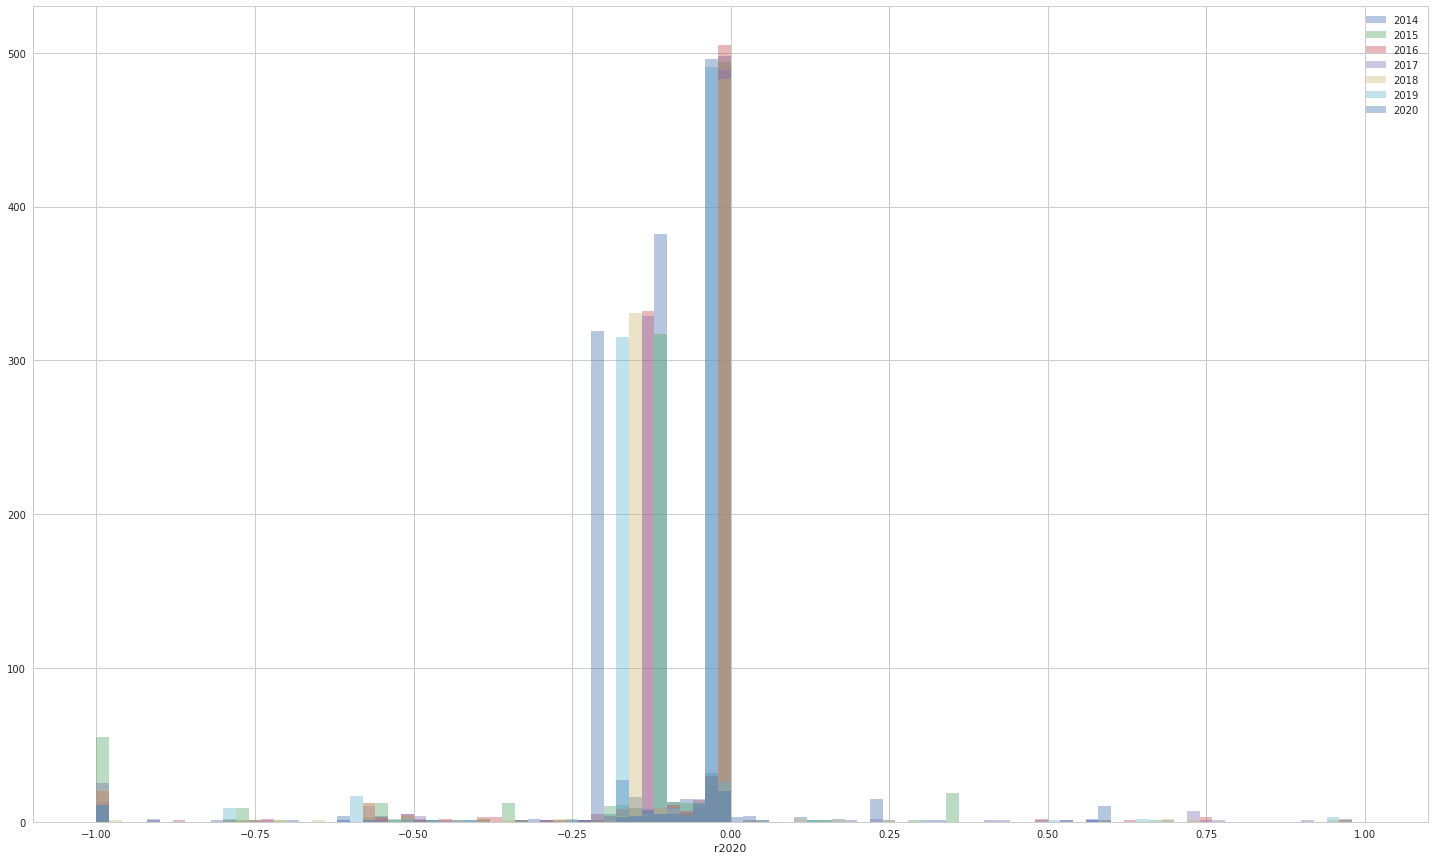

In [170]:
MIN, MAX = -1, 1
plt.figure(figsize=(25,15))

for year in YEARS[1:]:
    sns.distplot(
        data['r' + year],
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

#### Closer look at distributions for installations reducing their emissions

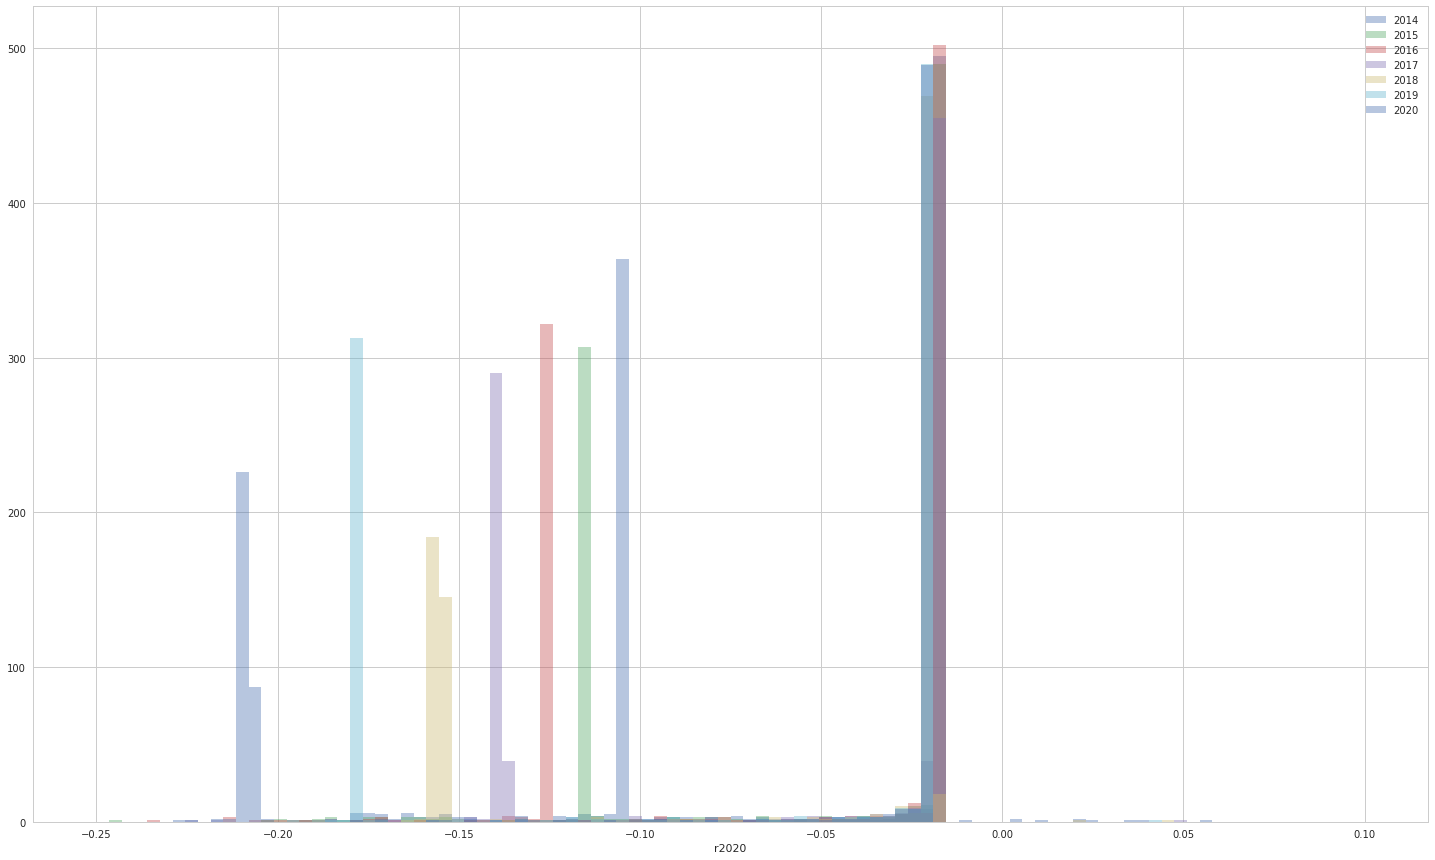

In [171]:
MIN, MAX = -0.25, 0.1
plt.figure(figsize=(25,15))

for year in YEARS[1:]:
    sns.distplot(
        data[data['r' + year] > MIN]['r' + year],
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

##### Installations showing high decrease (~20%)

In [189]:
data[(data['r2020'] < -0.20) & (data['r2020'] > -0.24)].sort_values(by=['2020'], ascending=False)[['installationName', '2020', 'r2020']].head(n=10)

,installationName,2020,r2020
559,CPCU - Chaufferie de Saint Ouen I et II,101540,-0.208900
839,Centrale Utilités SOBEGI,76269,-0.208893
433,SNC COGE VITRY,56220,-0.207935
1042,UNILIN SAS,42864,-0.208889
434,CPCU - chaufferie de Saint-Ouen III,42053,-0.207937
729,Station de Bavay (GDF),31681,-0.208905
794,SWISS KRONO SAS,26667,-0.208906
1034,ARMSTRONG BUILDING PRODUCTS SAS,21065,-0.222579
538,CPCU - Chaufferie de Vaugirard,20112,-0.208905
541,ENERTHEM - Centrale Alençon,19090,-0.208901


Proportion of installations common to 2020 and 2019 within these subsets

In [190]:
s2020 = set(data[(data['r2020'] < -0.20) & (data['r2020'] > -0.24)].sort_values(by=['2020'], ascending=False)['installationName'])
s2019 = set(data[(data['r2019'] < -0.15) & (data['r2019'] > -0.20)].sort_values(by=['2019'], ascending=False)['installationName'])
len(s2019.intersection(s2020)) / len(s2019)

0.9498432601880877

#### Even closer look

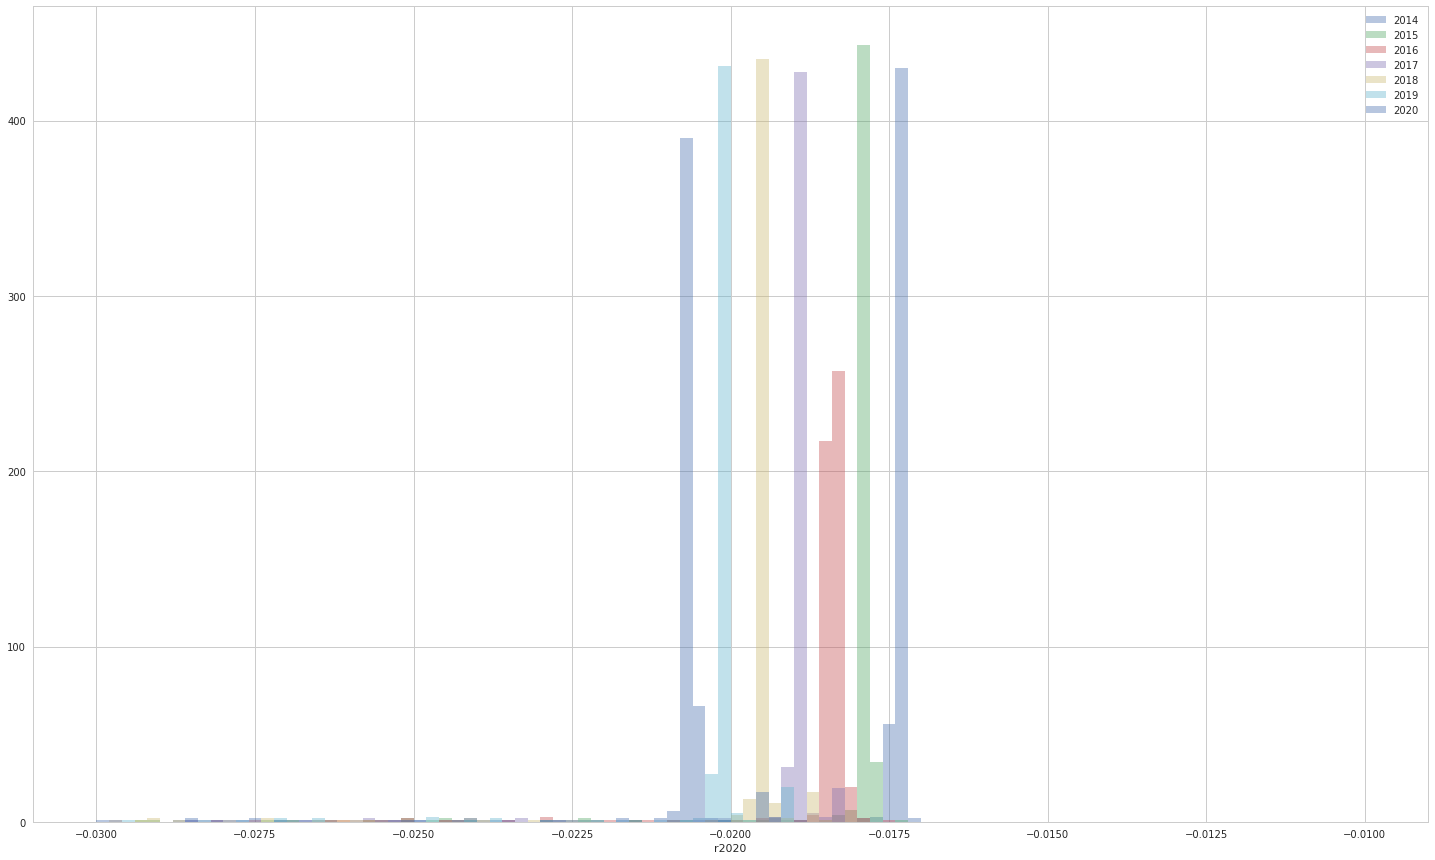

In [175]:
MIN, MAX = -0.03, -0.01
plt.figure(figsize=(25,15))

for year in YEARS[1:]:
    sns.distplot(
        data[(data['r' + year] > MIN) & (data['r' + year] < MAX)]['r' + year],
        label=year,
        bins=100,
        kde=False,
        hist_kws={
            "range": (MIN, MAX)
        }
    )
plt.legend()
plt.show()

##### Installations showing low decrease (~2%)

In [192]:
data[(data['r2020'] < -0.02) & (data['r2020'] > -0.0225)].sort_values(by=['2020'], ascending=False)[['installationName', '2020', 'r2020']].head(n=20)

,installationName,2020,r2020
695,ArcelorMittal Atlantique et Lorraine - Dunkerque,8291093,-0.020621
464,ARCELORMITTAL MEDITERRANEE,5994660,-0.020621
188,Raffinerie de Normandie,1607905,-0.020621
192,ESSO RAFFINAGE SAF,1279341,-0.020620
191,EXXONMOBIL CHEMICAL FRANCE,1094282,-0.020622
452,Raffinerie de Lavera,1021606,-0.020621
412,Raffinerie de Donges,983040,-0.020621
454,NAPHTACHIMIE - Usine de Lavéra,939513,-0.020819
458,Usine chimique de l'Aubette,928640,-0.020621
280,VICAT Usine de Montalieu,834031,-0.020621


Proportion of installations common to 2020 and 2019 within these subsets

In [193]:
s2020 = set(data[(data['r2020'] < -0.02) & (data['r2020'] > -0.0225)].sort_values(by=['2020'], ascending=False)['installationName'])
s2019 = set(data[(data['r2019'] < -0.018) & (data['r2019'] > -0.022)].sort_values(by=['2019'], ascending=False)['installationName'])
len(s2019.intersection(s2020)) / len(s2019)

0.9404517453798767

### 2020's relative trend vs total emissions

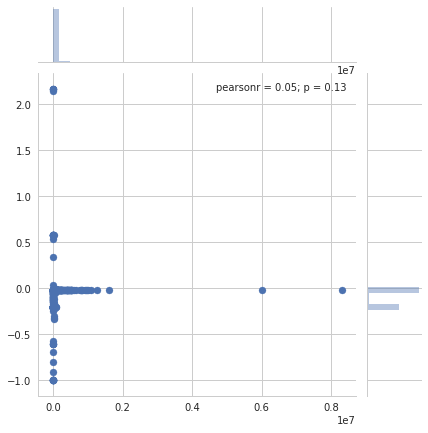

In [221]:
sns.jointplot(
    np.array(data['2020']),
    np.array(data['r2020']),
    kind="scatter"
)

### 2020's relative trend vs _log_ total emissions

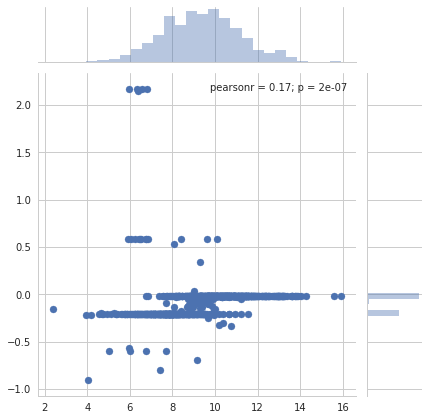

In [222]:
sns.jointplot(
    np.log(np.array(data[data['2020'] > 0]['2020'])),
    np.array(data[data['2020'] > 0]['r2020']),
    kind="scatter"
)